# Get Reddit OMSCS 2022 Application Details

### Instructions
- Get Reddit API keys from here: [https://www.reddit.com/prefs/apps](https://www.reddit.com/prefs/apps)
- Add credentials to the .env file (see the example file: example.env)
- Run script and have fun

### Imports

In [1]:
import os
import pandas as pd
import praw

from dotenv import load_dotenv

### API Setup / variables / settings

In [2]:
# Load environment variables
load_dotenv()

reddit = praw.Reddit(client_id=os.environ.get('CLIENT_ID'),
                     client_secret=os.environ.get('CLIENT_SECRET'),
                     user_agent=os.environ.get('USER_AGENT'))

# Define the subreddit and the thread ID
subreddit_name = 'OMSCS'
thread_id = 'spbavt'

# Show all rows and columns in Pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Functions

In [3]:
def find_between(s, first, last):
    try:
        start = s.index(first) + len(first)
        end = s.index(last, start)
        return s[start:end]
    except ValueError:
        return ""

### Get Data

In [4]:
# Get the submission object for the thread
submission = reddit.submission(id=thread_id)

# Get all top-level comments and their replies
comments = submission.comments.list()

# Print all top-level comments and their replies
n = 0
dict_responses = {}
for comment in comments:
    try:
        # print(comment.body)
        s_application_date = find_between(s=comment.body, first='Application Date:** ', last='\n')
        s_decision_date = find_between(s=comment.body, first='Decision Date:** ', last='\n')
        s_status = find_between(s=comment.body, first='Status:** ', last='\n')
        # for reply in comment.replies:
        #     print('\t' + reply.body)
        if s_decision_date == '':
            continue
        else:
            dict_responses[n] = {'application_date': s_application_date, 'decision_date': s_decision_date, 'status': s_status}
    except AttributeError:
        continue
    n += 1


df = pd.DataFrame.from_dict(dict_responses, orient='index')

In [5]:
df.sample(n=5)

,application_date,decision_date,status
32,03/09/22,04/20/22,Accepted
33,02/14/22,04/20/22,Accepted
51,03/07/22,04/25/22,Accepted
82,03/07/2022,04/29/2022 9:47am EST,Accepted
36,03/08/2022,04/29/2022,ACCEPTED (applied 2nd time)


### Clean data

In [6]:
# Decision date (not the cleanest, but gets the job done)
replacements = \
    {'03': '3', '04': '4', '05': '5', '06': '6', '09': '9', 'May': '5', '\r': '', '\\\\': '', '<': '', '>': ''}
df['decision_date_cleaned1'] = df['decision_date'].replace(replacements, regex=True).str.strip()
# Take first part supplied
df['decision_date_cleaned2'] = df['decision_date_cleaned1'].apply(lambda x: x.split(' ')[0])
# One of clean up
df['decision_date_cleaned2'].replace('4/27', '4/27/2022', inplace=True)
df['decision_date_cleaned3'] = pd.to_datetime(df['decision_date_cleaned2'], errors='coerce')
df['decision_day'] = df['decision_date_cleaned3'].dt.day_name()
df['decision_dayofweek_number'] = df['decision_date_cleaned3'].dt.dayofweek
# Status
df['status_cleaned'] = df['status']\
    .replace({'\r': '', '\\': '', '<': '', '>': '', '[': '', ']': ''})\
    .str.strip()\
    .str.lower()\
    .apply(lambda x: x.split(' ')[0].replace('\\', '').replace('!', ''))
df['status_cleaned'] = df['status_cleaned'].str.replace(r'\[<(.+?)>\].*', r'\1', regex=True)
df['status_cleaned'].replace('', 'unknown', inplace=True)

In [7]:
df.sample(n=5)

,application_date,decision_date,status,decision_date_cleaned1,decision_date_cleaned2,decision_date_cleaned3,decision_day,decision_dayofweek_number,status_cleaned
6,02/24/2022,04/11/2022,Accepted,4/11/2022,4/11/2022,2022-04-11,Monday,0.0,accepted
109,02/21/22,04/13/22,Accepted,4/13/22,4/13/22,2022-04-13,Wednesday,2.0,accepted
39,03/07/2022,04/27/2022,Accepted,4/27/2022,4/27/2022,2022-04-27,Wednesday,2.0,accepted
8,02/12/2022,04/22/2022 10:16 AM ET,Accepted,4/22/2022 10:16 AM ET,4/22/2022,2022-04-22,Friday,4.0,accepted
40,2021-09-03,2022-03-18,Accepted,2022-3-18,2022-3-18,2022-03-18,Friday,4.0,accepted


### Summarize and combine

In [8]:
df_dates = pd.DataFrame({'date_': pd.date_range(start=df['decision_date_cleaned3'].min(), end=df['decision_date_cleaned3'].max())})
df_counts = pd.DataFrame(df.groupby(by=['decision_date_cleaned3', 'decision_day']).size()).reset_index()
df_combined = pd.merge(left=df_dates, right=df_counts, left_on='date_', right_on='decision_date_cleaned3', how='left')
df_combined.rename(columns={0: 'responses'}, inplace=True)
df_combined.fillna(0, inplace=True)

In [9]:
df_combined.sample(n=5)

,date_,decision_date_cleaned3,decision_day,responses
1,2022-03-19,0,0,0.0
30,2022-04-17,0,0,0.0
17,2022-04-04,2022-04-04 00:00:00,Monday,1.0
3,2022-03-21,0,0,0.0
16,2022-04-03,0,0,0.0


### Review

Plot responses by day

/var/folders/ww/pclpdvcn0_q4xgsflv1vs1400000gn/T/ipykernel_25437/336006265.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  ax.get_figure().show()


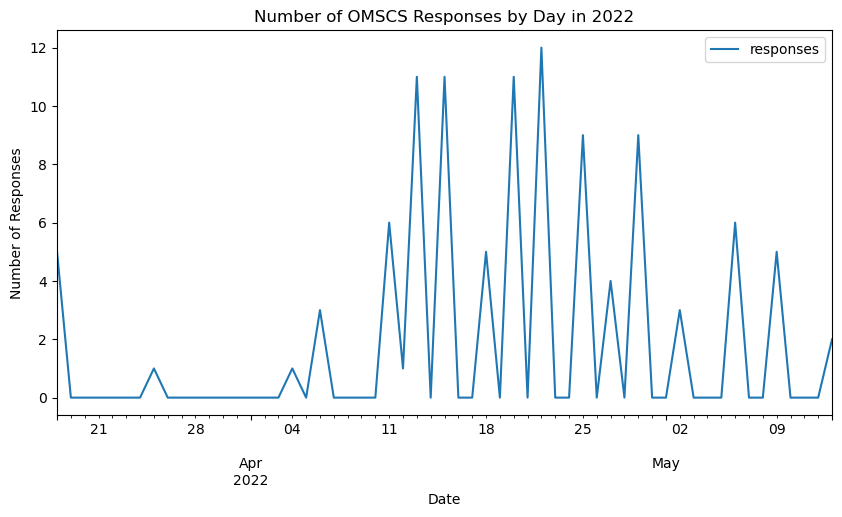

In [10]:
# Show plot
ax = df_combined.plot(
    x='date_',
    y='responses',
    kind='line',
    title='Number of OMSCS Responses by Day in 2022',
    xlabel='Date',
    ylabel='Number of Responses',
    figsize=(10, 5))
ax.get_figure().show()
# ax.get_figure().savefig('decision_date_trend.png', format='png')

In [11]:
# Review counts of statuses
df.groupby(by='status_cleaned').size()

status_cleaned
accepted    98
applied      3
pending      1
rejected     2
unknown      6
dtype: int64

In [12]:
print('Number of decisions received by day of week')
df.groupby(by=['decision_date_cleaned3', 'decision_dayofweek_number', 'decision_day']).agg({'decision_dayofweek_number': ['count', 'size']})
df_dow = df.groupby(by=['decision_dayofweek_number', 'decision_day']).size().reset_index()
df_dow.rename(columns={0: 'responses'}, inplace=True)
n_responses = df_dow['responses'].sum()
df_dow['pct_of_total'] = df_dow.apply(lambda x: round(x['responses']/n_responses*100, 2), axis=1)

df_dow

Number of decisions received by day of week


,decision_dayofweek_number,decision_day,responses,pct_of_total
0,0.0,Monday,29,27.62
1,1.0,Tuesday,1,0.95
2,2.0,Wednesday,29,27.62
3,4.0,Friday,46,43.81


In [13]:
print('Frequency that decisions are sent out on a day of the week')
df_dow_simp = df.query("decision_day != 'Tuesday'")  # Dropping the one Tuesday, because I don't trust it
df_dow_simp = df_dow_simp[['decision_date_cleaned3', 'decision_dayofweek_number', 'decision_day']].drop_duplicates().sort_values(by='decision_date_cleaned3')
df_dow_simp = df_dow_simp.groupby(by='decision_day').agg({'decision_dayofweek_number': 'min', 'decision_day': 'count'}).sort_values(by='decision_dayofweek_number')
df_dow_simp = df_dow_simp.rename(columns={'decision_dayofweek_number': 'day_of_week_number', 'decision_day': 'frequency'}).reset_index()
n_days_decisions_released = df_dow_simp['frequency'].sum()
df_dow_simp['pct_occurrence'] = df_dow_simp['frequency'].apply(lambda x: round(x/n_days_decisions_released * 100, 2))
df_dow_simp

Frequency that decisions are sent out on a day of the week


,decision_day,day_of_week_number,frequency,pct_occurrence
0,Monday,0.0,6,35.29
1,Wednesday,2.0,4,23.53
2,Friday,4.0,7,41.18
